## __Import libraries__

In [1]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/jovyan/accesibilidad-urbana


In [8]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import osmnx as ox

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    print(f"Path found.")
    sys.path.append(module_path)
    import aup
else:
    print(f"Path already loaded.")
    import aup

repo_path = str(module_path)+"/"
print(f"Repo path: {repo_path}")

Path already loaded.
Repo path: /home/jovyan/accesibilidad-urbana/


## __Notebook config__

In [3]:
# ----- ----- ----- Input configuration
project_path = repo_path + "data/projects/30_taojuan/"

# ----- ----- ----- Process configuration
projected_crs = "EPSG:32651"

# ----- ----- ----- Saving configuration
# save output to database?
save = False
if_exists='replace'

## __Load nodes and edges__

In [4]:
# Load test nodes
#nodes_gdf = gpd.read_file(project_path+"nodes_distance_matrix/taoyuan_nodes_test.gpkg")
#if nodes_gdf.crs != "EPSG:4326":
#    nodes_gdf = nodes_gdf.to_crs("EPSG:4326")

nodes_schema = 'projects_research'
nodes_table = 'taoyuan_nodes_aoipoly'

query = f"SELECT * FROM {nodes_schema}.{nodes_table}"
nodes_gdf = aup.gdf_from_query(query, geometry_col='geometry')
if nodes_gdf.crs != "EPSG:4326":
    nodes_gdf = nodes_gdf.to_crs("EPSG:4326")

# Show
print(nodes_gdf.crs)
print(nodes_gdf.shape)
nodes_gdf.head(2)

epsg:4326
(319893, 5)


,osmid,x,y,street_count,geometry
0,25937580,121.105229,24.744270,4,POINT (121.10523 24.74427)
1,25937585,121.105527,24.745379,3,POINT (121.10553 24.74538)


In [5]:
# Load test edges
#edges_gdf = gpd.read_file(project_path+"nodes_distance_matrix/taoyuan_edges_test.gpkg")
#if edges_gdf.crs != "EPSG:4326":
#    edges_gdf = edges_gdf.to_crs("EPSG:4326")

edges_schema = 'projects_research'
edges_table = 'taoyuan_edges_aoipoly'

query = f"SELECT * FROM {edges_schema}.{edges_table}"
edges_gdf = aup.gdf_from_query(query, geometry_col='geometry')
if edges_gdf.crs != "EPSG:4326":
    edges_gdf = edges_gdf.to_crs("EPSG:4326")

# Show
print(edges_gdf.crs)
print(edges_gdf.shape)
edges_gdf.head(2)

epsg:4326
(820238, 18)


,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service
0,25937580,25941243,0,8169126,False,None,None,unclassified,None,46.828163,"LINESTRING (121.10523 24.74427, 121.10483 24.7...",None,None,None,None,None,None,None
1,25937580,10657185313,0,8035771,False,None,福晶街2巷,service,None,74.268172,"LINESTRING (121.10523 24.74427, 121.10532 24.7...",None,None,None,None,None,None,alley


In [18]:
consolidate = (True,10)

if consolidate[0]:
    # Make sure indexes are set
    if 'osmid' in nodes_gdf.columns:
        print('Setting osmid as nodes index.')
        nodes_gdf = nodes_gdf.set_index('osmid')

    if ('u' in edges_gdf.columns) | ('v' in edges_gdf.columns) | ('key' in edges_gdf.columns):
        print('Setting u, v and key as edges index.')
        edges_gdf = edges_gdf.set_index(["u", "v", "key"])

    # Make crs is set to projected
    if nodes_gdf.crs != projected_crs:
        print('Setting nodes crs as projected crs.')
        nodes_gdf = nodes_gdf.to_crs(projected_crs)
    if edges_gdf.crs != projected_crs:
        print('Setting edges crs as projected crs.')
        edges_gdf = edges_gdf.to_crs(projected_crs)

    # Create graph
    print('Creating graph.')
    G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)
    
    # consolidate graph
    print(f"Consolidating graph using tolerance of {consolidate[1]} meters...")
    G2 = ox.consolidate_intersections(G, rebuild_graph=True, tolerance=consolidate[1], dead_ends=True)
    del G #Save space
    
    # Extract nodes and edges from consolidated graph
    print(f"Extracting nodes and edges from consolidated graph.")
    nodes_simp, edges_simp = ox.graph_to_gdfs(G2)
    del G2 #Save space
    
    # Format nodes
    print('Formating nodes.')
    nodes_simp = nodes_simp.reset_index()
    nodes_simp = nodes_simp.drop(columns=['osmid'])
    nodes_simp = nodes_simp.rename(columns={'osmid_original':'osmid'})
    nodes_simp = nodes_simp.set_index('osmid')
    if 'index' in nodes_simp.columns:
        nodes_simp = nodes_simp.drop(columns=['index'])
    
    # Format edges
    print('Formating edges.')
    edges_simp = edges_simp.reset_index()
    edges_simp = edges_simp.drop(columns=['u','v'])
    edges_simp = edges_simp.rename(columns={'u_original':'u',
    'v_original':'v'})
    edges_simp = edges_simp.set_index(['u','v','key'])
    if 'index' in edges_simp.columns:
        edges_simp = edges_simp.drop(columns=['index'])

Setting nodes crs as projected crs.
Setting edges crs as projected crs.
Creating graph.


/tmp/ipykernel_28245/4234836885.py:23: UserWarning: discarding the gdf_nodes geometry column, though its values differ from the coordinates in the x and y columns
  G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)


Consolidating graph using tolerance of 10 meters...
Extracting nodes and edges from consolidated graph.
Formating nodes.


In [19]:
# Show
print(nodes_simp.crs)
print(nodes_simp.shape)
nodes_simp.head(1)

EPSG:32651
(1, 5)


,osmid_original,x,y,street_count,geometry
osmid,,,,,
0,"[25937580, 25941243, 10657185313, 9266009694, ...",121.442544,24.875868,0,POINT (121.443 24.876)


In [20]:
# Show
print(edges_simp.crs)
print(edges_simp.shape)
edges_simp.head(1)

EPSG:32651
(1593, 16)


,,,osmid,oneway,highway,length,geometry,service,u_original,v_original,access,name,bridge,width,junction,tunnel,lanes,maxspeed
u,v,key,,,,,,,,,,,,,,,,
0,0,0,93523127,False,service,2.752245e+06,"LINESTRING (121.443 24.876, 315897.284 2733813...",parking_aisle,2498798618,2498798618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

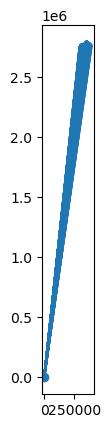

In [21]:
fig,ax = plt.subplots()

nodes_simp.plot(ax=ax)
edges_simp.plot(ax=ax)